<a href="https://colab.research.google.com/github/LeonGoergen/informationExtraction/blob/main/ner/administration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://huggingface.co/docs/transformers/tasks/token_classification

# Dependencies

In [ ]:
from numba import cuda

device = cuda.get_current_device()
device.reset()

In [ ]:
from huggingface_hub import login
login(token="hf_gqwmWYqkoAMZsuraWMUycINzNzOusuhLDcX")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Installations

In [ ]:
!pip install datasets
!pip install evaluate
!pip install seqeval
!pip install transformers[torch]
!pip install scikit-metrics
!pip install sacremoses

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=d2d9d22c89b2a505727026e7ac61c6cc9fff9fa21bfc1280d2dbafc855d7e790
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
  Preparing metadata (setup.py) ... done
  C

In [ ]:
exit(0)

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, pipeline, DataCollatorForTokenClassification
import datasets
from datasets import Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from collections import Counter
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

## Data

In [ ]:
train = pd.read_json('/content/drive/MyDrive/Masterarbeit/Public administration/train.json')
test = pd.read_json('/content/drive/MyDrive/Masterarbeit/Public administration/test.json')

len(train), len(test)

(18490, 3264)

In [ ]:
unique_tags = set()
for tags in train['ner_tags']:
  for tag in tags:
    unique_tags.add(tag)

labels_to_ids = {k: v for v, k in enumerate(unique_tags)}
ids_to_labels = {v: k for v, k in enumerate(unique_tags)}

## Classes

In [ ]:
class ModelTrainer():
  def __init__(self, model_name, tokenizer_name, ids_to_labels, labels_to_ids, prefix_space=False, **kwargs):
    self.label_list = [ids_to_labels[i] for i in range(len(labels_to_ids))]
    self.labels_to_ids = labels_to_ids
    self.ids_to_labels = ids_to_labels

    self.model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(self.label_list),
                                                                 id2label=ids_to_labels, label2id=labels_to_ids,
                                                                 ignore_mismatched_sizes=True, **kwargs)
    for param in self.model.parameters(): param.data = param.data.contiguous()
    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, add_prefix_space=prefix_space)

    if self.tokenizer.pad_token is None:
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model.config.pad_token_id = self.model.config.eos_token_id
        self.model.resize_token_embeddings(len(self.tokenizer))

    self.data_collator = DataCollatorForTokenClassification(self.tokenizer)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

  def train(self, df, training_args):
    self.__prepare_data(df)

    self.trainer = Trainer(
      model=self.model,
      args=training_args,
      train_dataset=self.train,
      eval_dataset=self.eval,
      tokenizer=self.tokenizer,
      data_collator=self.data_collator,
      compute_metrics=self.__compute_metrics,
    )

    self.trainer.train()

  def save(self, name):
    self.trainer.save_model("/content/" + name + "/final")
    zip_command = f'zip -r "/content/drive/MyDrive/Masterarbeit/Models/admin_ner_{name}.zip" "/content/{name}/final"'
    !{zip_command}

  def evaluate_training(self):
    train_losses = []
    eval_losses = []

    for d in self.trainer.state.log_history:
      if "loss" in d:
        train_losses.append(d["loss"])
      elif "eval_loss" in d:
        eval_losses.append(d["eval_loss"])

    plt.plot(train_losses, label='train')
    plt.plot(eval_losses, label='eval')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show();

  def __prepare_data(self, df):
    train_dataset, eval_dataset = train_test_split(df, test_size=0.15, random_state=1)

    train_hugging = Dataset.from_pandas(train_dataset)
    eval_hugging = Dataset.from_pandas(eval_dataset)

    train_untokenized = train_hugging.map(self.__encode_tags)
    eval_untokenized = eval_hugging.map(self.__encode_tags)

    self.train = train_untokenized.map(self.__tokenize_and_align_labels, batched=True)
    self.eval = eval_untokenized.map(self.__tokenize_and_align_labels, batched=True)

  def __encode_tags(self, examples):
    examples['ner_tags'] = [self.labels_to_ids[tag] for tag in examples['ner_tags']]
    return examples

  def __tokenize_and_align_labels(self, examples):
    tokenized_inputs = self.tokenizer(
        examples["tokens"],
        truncation=True,
        max_length=512,
        is_split_into_words=True,
        padding='max_length'
    )

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
      word_ids = tokenized_inputs.word_ids(batch_index=i)
      previous_word_idx = None
      label_ids = []
      for word_idx in word_ids:
        if word_idx is None:
          label_ids.append(-100)
        elif word_idx != previous_word_idx:
          label_ids.append(label[word_idx])
        else:
          label_ids.append(-100)
        previous_word_idx = word_idx
      labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

  def __compute_metrics(self, p):
    seqeval = evaluate.load("seqeval")
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
      [self.label_list[p] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
      [self.label_list[l] for (p, l) in zip(prediction, label) if l != -100]
      for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    return {
      "precision": results["overall_precision"],
      "recall": results["overall_recall"],
      "f1": results["overall_f1"],
      "accuracy": results["overall_accuracy"],
    }

In [ ]:
class ModelPipe():
  def __init__(self, model_name, tokenizer_name):
    rm_command = f'rm -rf "/content/{model_name}/final"'
    !{rm_command}

    mkdir_command = f'mkdir -p "/content/{model_name}/final"'
    !{mkdir_command}

    unzip_command = f'unzip "/content/drive/MyDrive/Masterarbeit/Models/admin_ner_{model_name}.zip" -d "/content/{model_name}/final"'
    !{unzip_command}

    self.model = AutoModelForTokenClassification.from_pretrained("/content/" + model_name + "/final/content/" + model_name + "/final")
    self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, is_split_into_words=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(device)

    self.pipe = pipeline("ner", model=self.model, tokenizer=self.tokenizer, aggregation_strategy="max", device=0)

  def inference(self, text):
    result = self.pipe(text)
    return result

  def evaluate(self, df):
    self.all_predictions = []
    self.all_ground_truth = []

    for idx, example in tqdm(df.iterrows(), total=df.shape[0]):
      predictions = pipe.inference(' '.join(example['tokens']))
      tokens = example['tokens']
      ground_truth = example['ner_tags']

      y_pred = self.__align_predictions_with_tokens(predictions, self.__get_token_char_indices(tokens))
      y_true = self.__convert_to_true_entities(ground_truth)

      self.all_predictions.extend(y_pred)
      self.all_ground_truth.extend(y_true)

  def __get_token_char_indices(self, tokens):
    text = ' '.join(tokens)
    token_indices = []
    current_index = 0
    for token in tokens:
      start_index = text.index(token, current_index)
      end_index = start_index + len(token)
      token_indices.append((start_index, end_index))
      current_index = end_index + 1
    return token_indices

  def __convert_to_true_entities(self, ner_tags):
    new_ner_tags = []
    for tag in ner_tags:
      if tag.startswith('B-') or tag.startswith('I-'):
        new_ner_tags.append(tag[2:])
      else:
        new_ner_tags.append(tag)
    return new_ner_tags

  def __align_predictions_with_tokens(self, predictions, token_indices):
    aligned_predictions = ['O'] * len(token_indices)
    for pred in predictions:
      entity_group = pred['entity_group']
      start_char = pred['start']
      end_char = pred['end']
      for i, (start_token, end_token) in enumerate(token_indices):
        if start_token >= start_char and end_token <= end_char:
          aligned_predictions[i] = f'{entity_group}'
        elif start_token <= start_char < end_token or start_token < end_char <= end_token:
          aligned_predictions[i] = f'{entity_group}'
    return aligned_predictions

  def print_classification_report(self):
    labels = list(set(self.all_ground_truth) | set(self.all_predictions))

    report = classification_report(self.all_ground_truth, self.all_predictions, labels=labels, digits=3)
    print(report)

  def print_confusion_matrix(self):
    labels = list(set(self.all_ground_truth) | set(self.all_predictions))

    conf_matrix = confusion_matrix(self.all_ground_truth, self.all_predictions, labels=labels)

    # Normalize the confusion matrix
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# BERT

In [ ]:
model_name = "bert-base"

##Training

In [ ]:
model = ModelTrainer("bert-base-german-cased", "bert-base-german-cased", ids_to_labels, labels_to_ids)

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)


Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.555275,0.288456,0.263820,0.275588,0.792534
2,No log,0.522154,0.375238,0.362064,0.368533,0.801401
3,0.637900,0.505211,0.387126,0.444328,0.413759,0.806847


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


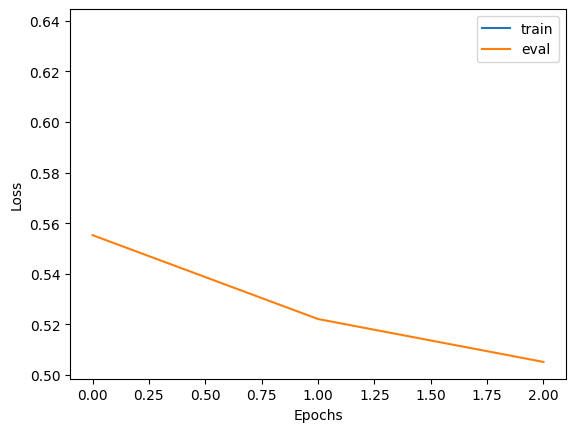

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/bert-base/final/ (stored 0%)
  adding: content/bert-base/final/model.safetensors (deflated 7%)
  adding: content/bert-base/final/vocab.txt (deflated 57%)
  adding: content/bert-base/final/training_args.bin (deflated 51%)
  adding: content/bert-base/final/tokenizer.json (deflated 71%)
  adding: content/bert-base/final/special_tokens_map.json (deflated 42%)
  adding: content/bert-base/final/tokenizer_config.json (deflated 75%)
  adding: content/bert-base/final/config.json (deflated 62%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'bert-base-german-cased')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/admin_ner_bert-base.zip
   creating: /content/bert-base/final/content/bert-base/final/
  inflating: /content/bert-base/final/content/bert-base/final/model.safetensors  
  inflating: /content/bert-base/final/content/bert-base/final/vocab.txt  
  inflating: /content/bert-base/final/content/bert-base/final/training_args.bin  
  inflating: /content/bert-base/final/content/bert-base/final/tokenizer.json  
  inflating: /content/bert-base/final/content/bert-base/final/special_tokens_map.json  
  inflating: /content/bert-base/final/content/bert-base/final/tokenizer_config.json  
  inflating: /content/bert-base/final/content/bert-base/final/config.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
example_index = 6

print(test.iloc[example_index]['tokens'])
print(test.iloc[example_index]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[example_index]['tokens'])))

['Er', 'kann', 'durch', 'Erklärung', 'gegenüber', 'dem', 'Standesamt', 'seinen', 'Geburtsnamen', 'oder', 'den', 'Namen', 'wieder', 'annehmen', ',', 'den', 'er', 'bis', 'zur', 'Bestimmung', 'des', 'Lebenspartnerschaftsnamens', 'geführt', 'hat', ',', 'oder', 'dem', 'Lebenspartnerschaftsnamen', 'seinen', 'Geburtsnamen', 'oder', 'den', 'bis', 'zur', 'Bestimmung', 'des', 'Lebenspartnerschaftsnamens', 'geführten', 'Namen', 'voranstellen', 'oder', 'anfügen', '.']
['O', 'B-Signalwort', 'O', 'B-Dokument', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Aktion', 'O', 'O', 'O', 'B-Frist', 'I-Frist', 'I-Frist', 'O', 'O', 'B-Aktion', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Frist', 'I-Frist', 'I-Frist', 'O', 'O', 'O', 'O', 'B-Aktion', 'O', 'B-Aktion', 'O']
[{'entity_group': 'Signalwort', 'score': 0.87707525, 'word': 'kann', 'start': 3, 'end': 7}, {'entity_group': 'Dokument', 'score': 0.7661643, 'word': 'Erklärung', 'start': 14, 'end': 23}, {'entity_group': 'Hauptakteur', 'score':

In [ ]:
pipe.evaluate(test)

100%|██████████| 3264/3264 [00:41<00:00, 78.69it/s]


In [ ]:
pipe.print_classification_report()

                    precision    recall  f1-score   support

                 O      0.874     0.887     0.880     55054
             Frist      0.412     0.253     0.313       435
        Signalwort      0.523     0.650     0.580       717
 Ergebnisempfänger      0.551     0.460     0.501       422
         Datenfeld      0.781     0.086     0.155       581
          Dokument      0.596     0.302     0.401       712
      Mitwirkender      0.336     0.165     0.221       279
       Hauptakteur      0.504     0.433     0.466       293
         Bedingung      0.663     0.668     0.666     11174
            Aktion      0.508     0.487     0.497      1095
Handlungsgrundlage      0.452     0.492     0.471      2529

          accuracy                          0.809     73291
         macro avg      0.564     0.444     0.468     73291
      weighted avg      0.807     0.809     0.805     73291



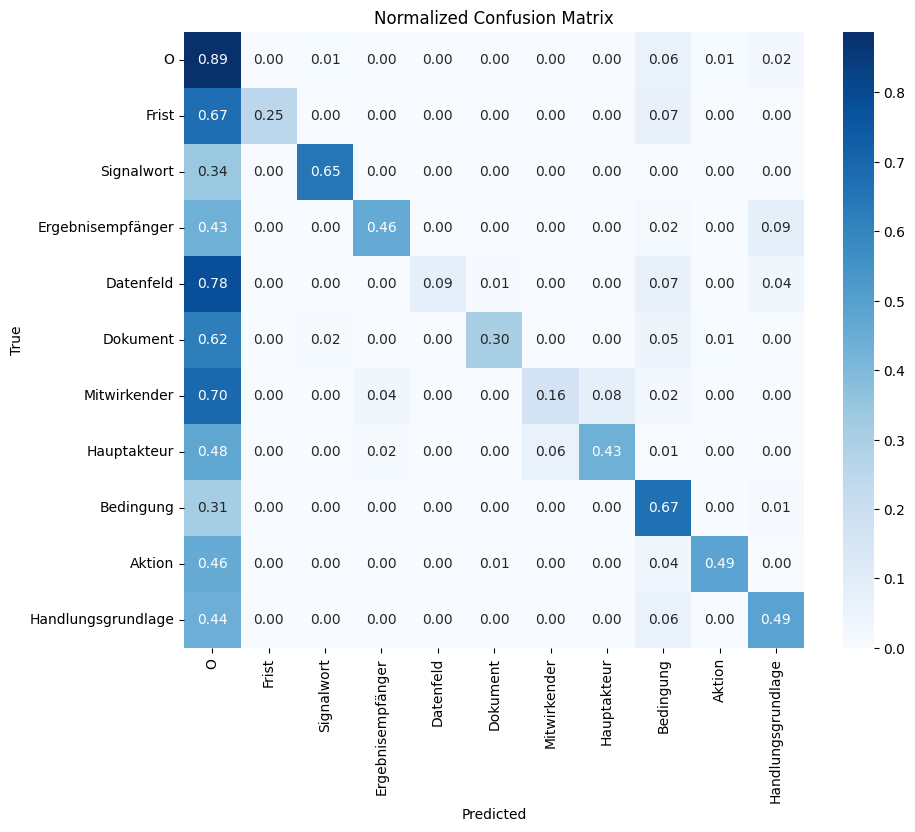

In [ ]:
pipe.print_confusion_matrix()

# RoBERTa

In [ ]:
model_name = "xlm-roberta-base"

##Training

In [ ]:
model = ModelTrainer("FacebookAI/xlm-roberta-base", "FacebookAI/xlm-roberta-base", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7fcbdc7eae60>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.800000,0.521145,0.333957,0.328084,0.330994,0.785134
2,0.455000,0.510091,0.406689,0.501050,0.448965,0.797636


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


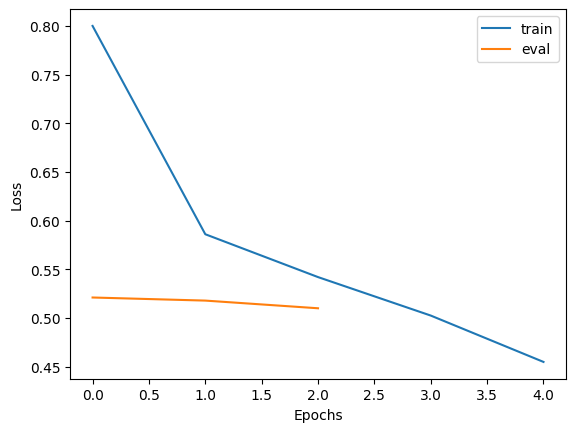

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/xlm-roberta-base/final/ (stored 0%)
  adding: content/xlm-roberta-base/final/sentencepiece.bpe.model (deflated 49%)
  adding: content/xlm-roberta-base/final/tokenizer_config.json (deflated 76%)
  adding: content/xlm-roberta-base/final/model.safetensors (deflated 29%)
  adding: content/xlm-roberta-base/final/training_args.bin (deflated 51%)
  adding: content/xlm-roberta-base/final/config.json (deflated 62%)
  adding: content/xlm-roberta-base/final/special_tokens_map.json (deflated 52%)
  adding: content/xlm-roberta-base/final/tokenizer.json (deflated 76%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'FacebookAI/xlm-roberta-base')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/admin_ner_xlm-roberta-base.zip
   creating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/sentencepiece.bpe.model  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/tokenizer_config.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/model.safetensors  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/training_args.bin  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/config.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/special_tokens_map.json  
  inflating: /content/xlm-roberta-base/final/content/xlm-roberta-base/final/tokenizer.json  


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['Zum', 'Nachweis', 'der', 'Tragfähigkeit', 'der', 'Existenzgründung', 'ist', 'der', 'Agentur', 'für', 'Arbeit', 'die', 'Stellungnahme', 'einer', 'fachkundigen', 'Stelle', 'vorzulegen', ';', 'fachkundige', 'Stellen', 'sind', 'insbesondere', 'die', 'Industriekammern', '-', 'und', 'Handelskammern', ',', 'Handwerkskammern', ',', 'berufsständische', 'Kammern', ',', 'Fachverbände', 'und', 'Kreditinstitute', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-Signalwort', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Dokument', 'O', 'O', 'B-Hauptakteur', 'B-Aktion', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O']
[{'entity_group': 'Signalwort', 'score': 0.6707202, 'word': 'ist', 'start': 52, 'end': 55}, {'entity_group': 'Hauptakteur', 'score': 0.44369337, 'word': 'Agentur', 'start': 60, 'end': 67}, {'entity_group': 'Dokument', 'score': 0.8460937, 'word': 'Stellungnahme', 'star

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3264/3264 [00:49<00:00, 66.37it/s]


In [ ]:
pipe.print_classification_report()

                    precision    recall  f1-score   support

                 O      0.877     0.856     0.867     55054
             Frist      0.413     0.297     0.345       435
        Signalwort      0.502     0.709     0.588       717
 Ergebnisempfänger      0.538     0.457     0.494       422
         Datenfeld      0.873     0.095     0.171       581
          Dokument      0.571     0.326     0.415       712
      Mitwirkender      0.254     0.125     0.168       279
       Hauptakteur      0.547     0.399     0.462       293
         Bedingung      0.600     0.688     0.641     11174
            Aktion      0.496     0.503     0.499      1095
Handlungsgrundlage      0.428     0.528     0.473      2529

          accuracy                          0.791     73291
         macro avg      0.554     0.453     0.466     73291
      weighted avg      0.799     0.791     0.791     73291



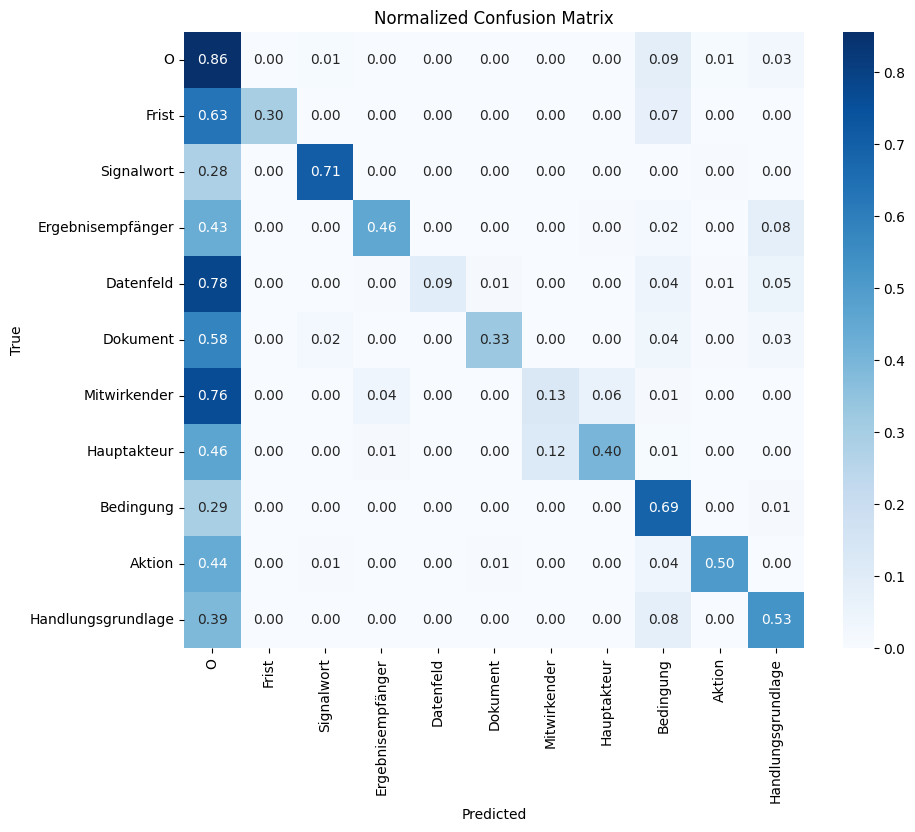

In [ ]:
pipe.print_confusion_matrix()

# ALBERT

In [ ]:
model_name = "albert-base"

##Training

In [ ]:
model = ModelTrainer("ArBert/albert-base-v2-finetuned-ner", "ArBert/albert-base-v2-finetuned-ner", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

Some weights of AlbertForTokenClassification were not initialized from the model checkpoint at ArBert/albert-base-v2-finetuned-ner and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([9, 768]) in the checkpoint and torch.Size([21, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([9]) in the checkpoint and torch.Size([21]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7bddf35ab910>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.739155,0.082560,0.023415,0.036483,0.762096
2,0.706200,0.650956,0.167163,0.088661,0.115867,0.779707


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


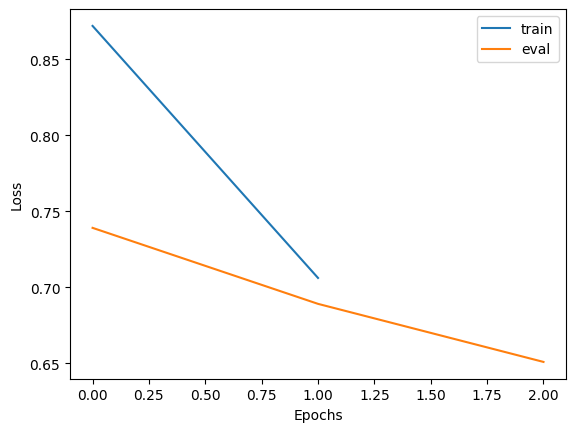

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/albert-base/final/ (stored 0%)
  adding: content/albert-base/final/tokenizer_config.json (deflated 74%)
  adding: content/albert-base/final/model.safetensors (deflated 7%)
  adding: content/albert-base/final/training_args.bin (deflated 51%)
  adding: content/albert-base/final/config.json (deflated 62%)
  adding: content/albert-base/final/special_tokens_map.json (deflated 84%)
  adding: content/albert-base/final/tokenizer.json (deflated 75%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'ArBert/albert-base-v2-finetuned-ner')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/admin_ner_albert-base.zip
   creating: /content/albert-base/final/content/albert-base/final/
  inflating: /content/albert-base/final/content/albert-base/final/tokenizer_config.json  
  inflating: /content/albert-base/final/content/albert-base/final/model.safetensors  
  inflating: /content/albert-base/final/content/albert-base/final/training_args.bin  
  inflating: /content/albert-base/final/content/albert-base/final/config.json  
  inflating: /content/albert-base/final/content/albert-base/final/special_tokens_map.json  
  inflating: /content/albert-base/final/content/albert-base/final/tokenizer.json  


tokenizer_config.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/245 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['Zum', 'Nachweis', 'der', 'Tragfähigkeit', 'der', 'Existenzgründung', 'ist', 'der', 'Agentur', 'für', 'Arbeit', 'die', 'Stellungnahme', 'einer', 'fachkundigen', 'Stelle', 'vorzulegen', ';', 'fachkundige', 'Stellen', 'sind', 'insbesondere', 'die', 'Industriekammern', '-', 'und', 'Handelskammern', ',', 'Handwerkskammern', ',', 'berufsständische', 'Kammern', ',', 'Fachverbände', 'und', 'Kreditinstitute', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-Signalwort', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Dokument', 'O', 'O', 'B-Hauptakteur', 'B-Aktion', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O']
[]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3264/3264 [00:54<00:00, 59.37it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

                 O      0.810     0.942     0.871     55054
             Frist      0.000     0.000     0.000       435
        Signalwort      0.526     0.042     0.078       717
         Datenfeld      0.000     0.000     0.000       581
          Dokument      0.875     0.010     0.019       712
      Mitwirkender      0.000     0.000     0.000       279
       Hauptakteur      0.000     0.000     0.000       293
         Bedingung      0.641     0.442     0.523     11174
 Ergebnisempfänger      0.400     0.005     0.009       422
            Aktion      0.622     0.056     0.102      1095
Handlungsgrundlage      0.456     0.248     0.321      2529

          accuracy                          0.785     73291
         macro avg      0.394     0.159     0.175     73291
      weighted avg      0.747     0.785     0.748     73291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


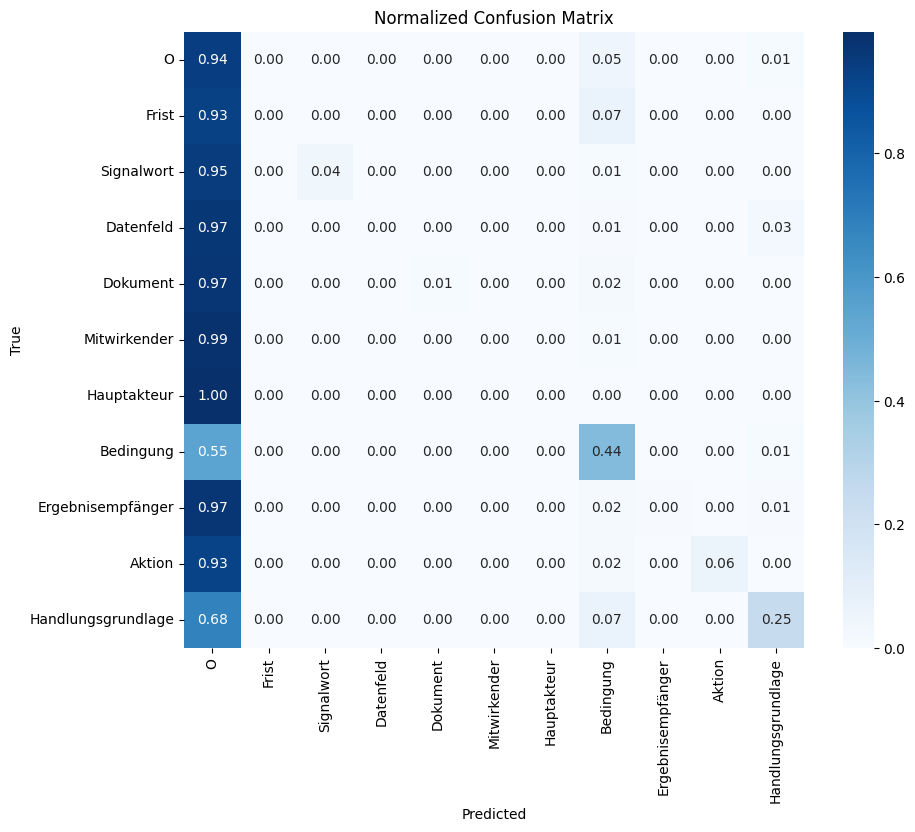

In [ ]:
pipe.print_confusion_matrix()

# GPT-2

In [ ]:
model_name = "gpt2-finetuned"

##Training

In [ ]:
model = ModelTrainer("dbmdz/german-gpt2", "dbmdz/german-gpt2", ids_to_labels, labels_to_ids, prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2ForTokenClassification were not initialized from the model checkpoint at dbmdz/german-gpt2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer.json:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7993a24efb20>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.666824,0.118981,0.078334,0.094471,0.775891
2,0.624400,0.616781,0.198331,0.137019,0.162070,0.786810


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


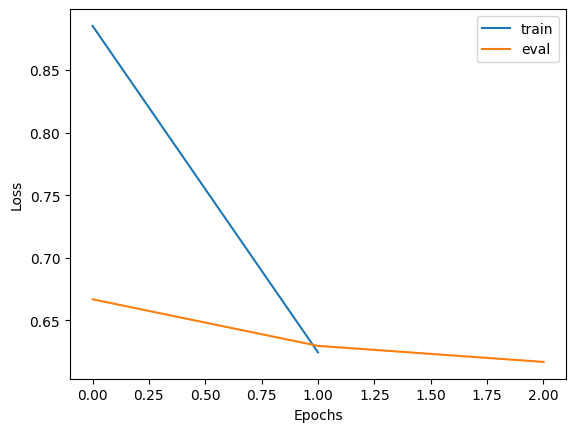

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/gpt2-finetuned/final/ (stored 0%)
  adding: content/gpt2-finetuned/final/tokenizer_config.json (deflated 80%)
  adding: content/gpt2-finetuned/final/merges.txt (deflated 55%)
  adding: content/gpt2-finetuned/final/model.safetensors (deflated 7%)
  adding: content/gpt2-finetuned/final/training_args.bin (deflated 51%)
  adding: content/gpt2-finetuned/final/added_tokens.json (stored 0%)
  adding: content/gpt2-finetuned/final/config.json (deflated 61%)
  adding: content/gpt2-finetuned/final/vocab.json (deflated 59%)
  adding: content/gpt2-finetuned/final/special_tokens_map.json (deflated 60%)
  adding: content/gpt2-finetuned/final/tokenizer.json (deflated 72%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'dbmdz/german-gpt2')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/admin_ner_gpt2-finetuned.zip
   creating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/tokenizer_config.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/merges.txt  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/model.safetensors  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/training_args.bin  
 extracting: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/added_tokens.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/config.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/vocab.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/special_tokens_map.json  
  inflating: /content/gpt2-finetuned/final/content/gpt2-finetuned/final/tokenizer.json  


config.json:   0%|          | 0.00/865 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.43M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['Zum', 'Nachweis', 'der', 'Tragfähigkeit', 'der', 'Existenzgründung', 'ist', 'der', 'Agentur', 'für', 'Arbeit', 'die', 'Stellungnahme', 'einer', 'fachkundigen', 'Stelle', 'vorzulegen', ';', 'fachkundige', 'Stellen', 'sind', 'insbesondere', 'die', 'Industriekammern', '-', 'und', 'Handelskammern', ',', 'Handwerkskammern', ',', 'berufsständische', 'Kammern', ',', 'Fachverbände', 'und', 'Kreditinstitute', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-Signalwort', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Dokument', 'O', 'O', 'B-Hauptakteur', 'B-Aktion', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O']
[{'entity_group': 'Aktion', 'score': 0.5017713, 'word': ' Nachweis', 'start': 3, 'end': 12}, {'entity_group': 'Dokument', 'score': 0.5229154, 'word': ' Stellungnahme', 'start': 82, 'end': 96}, {'entity_group': 'Aktion', 'score': 0.5184888, 'word': ' vorzulegen', 'star

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3264/3264 [00:38<00:00, 84.05it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

                 O      0.819     0.935     0.873     55054
             Frist      0.475     0.108     0.176       435
        Signalwort      0.514     0.226     0.314       717
 Ergebnisempfänger      0.656     0.100     0.173       422
         Datenfeld      0.000     0.000     0.000       581
          Dokument      0.731     0.096     0.169       712
      Mitwirkender      0.423     0.039     0.072       279
       Hauptakteur      0.650     0.044     0.083       293
         Bedingung      0.669     0.504     0.575     11174
            Aktion      0.502     0.194     0.279      1095
Handlungsgrundlage      0.470     0.178     0.258      2529

          accuracy                          0.793     73291
         macro avg      0.537     0.220     0.270     73291
      weighted avg      0.764     0.793     0.764     73291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


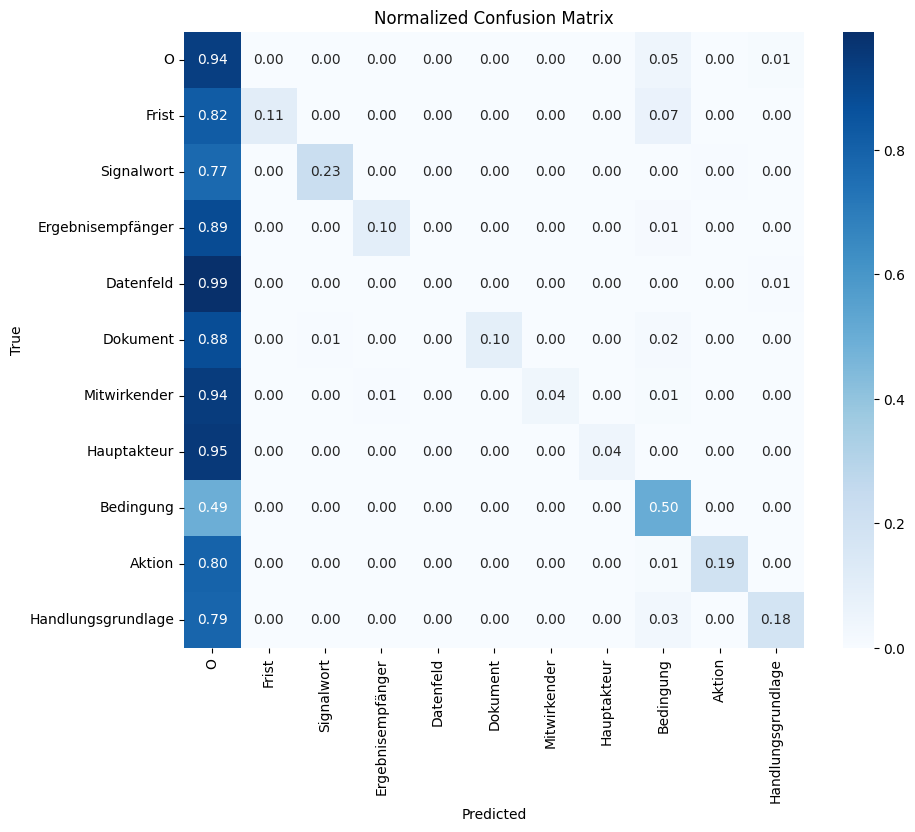

In [ ]:
pipe.print_confusion_matrix()

# GPT-Neo

In [ ]:
model_name = "gpt-neo"

##Training

In [ ]:
model = ModelTrainer("EleutherAI/gpt-neo-125M", "EleutherAI/gpt-neo-125M", ids_to_labels, labels_to_ids, prefix_space=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

Some weights of GPTNeoForTokenClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7c74e09ae200>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.700635,0.116032,0.068947,0.086497,0.778832
2,0.673300,0.659035,0.147000,0.097368,0.117144,0.786618


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


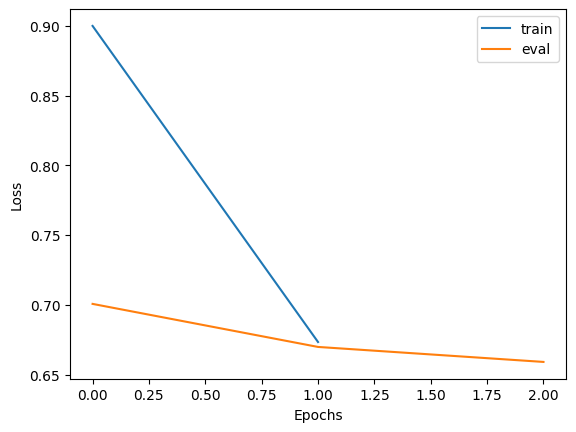

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/gpt-neo/final/ (stored 0%)
  adding: content/gpt-neo/final/tokenizer_config.json (deflated 55%)
  adding: content/gpt-neo/final/merges.txt (deflated 53%)
  adding: content/gpt-neo/final/model.safetensors (deflated 19%)
  adding: content/gpt-neo/final/training_args.bin (deflated 51%)
  adding: content/gpt-neo/final/config.json (deflated 65%)
  adding: content/gpt-neo/final/vocab.json (deflated 59%)
  adding: content/gpt-neo/final/special_tokens_map.json (deflated 74%)
  adding: content/gpt-neo/final/tokenizer.json (deflated 72%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'EleutherAI/gpt-neo-125M')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/admin_ner_gpt-neo.zip
   creating: /content/gpt-neo/final/content/gpt-neo/final/
  inflating: /content/gpt-neo/final/content/gpt-neo/final/tokenizer_config.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/merges.txt  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/model.safetensors  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/training_args.bin  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/config.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/vocab.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/special_tokens_map.json  
  inflating: /content/gpt-neo/final/content/gpt-neo/final/tokenizer.json  


tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

['Zum', 'Nachweis', 'der', 'Tragfähigkeit', 'der', 'Existenzgründung', 'ist', 'der', 'Agentur', 'für', 'Arbeit', 'die', 'Stellungnahme', 'einer', 'fachkundigen', 'Stelle', 'vorzulegen', ';', 'fachkundige', 'Stellen', 'sind', 'insbesondere', 'die', 'Industriekammern', '-', 'und', 'Handelskammern', ',', 'Handwerkskammern', ',', 'berufsständische', 'Kammern', ',', 'Fachverbände', 'und', 'Kreditinstitute', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-Signalwort', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Dokument', 'O', 'O', 'B-Hauptakteur', 'B-Aktion', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O']
[]


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3264/3264 [00:58<00:00, 55.99it/s]


In [ ]:
pipe.print_classification_report()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                    precision    recall  f1-score   support

                 O      0.802     0.953     0.871     55054
             Frist      0.381     0.018     0.035       435
        Signalwort      0.699     0.071     0.129       717
 Ergebnisempfänger      0.571     0.009     0.019       422
         Datenfeld      0.000     0.000     0.000       581
          Dokument      1.000     0.004     0.008       712
      Mitwirkender      0.211     0.029     0.050       279
       Hauptakteur      0.000     0.000     0.000       293
         Bedingung      0.672     0.405     0.506     11174
            Aktion      0.533     0.007     0.014      1095
Handlungsgrundlage      0.442     0.178     0.253      2529

          accuracy                          0.785     73291
         macro avg      0.483     0.152     0.171     73291
      weighted avg      0.751     0.785     0.742     73291



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


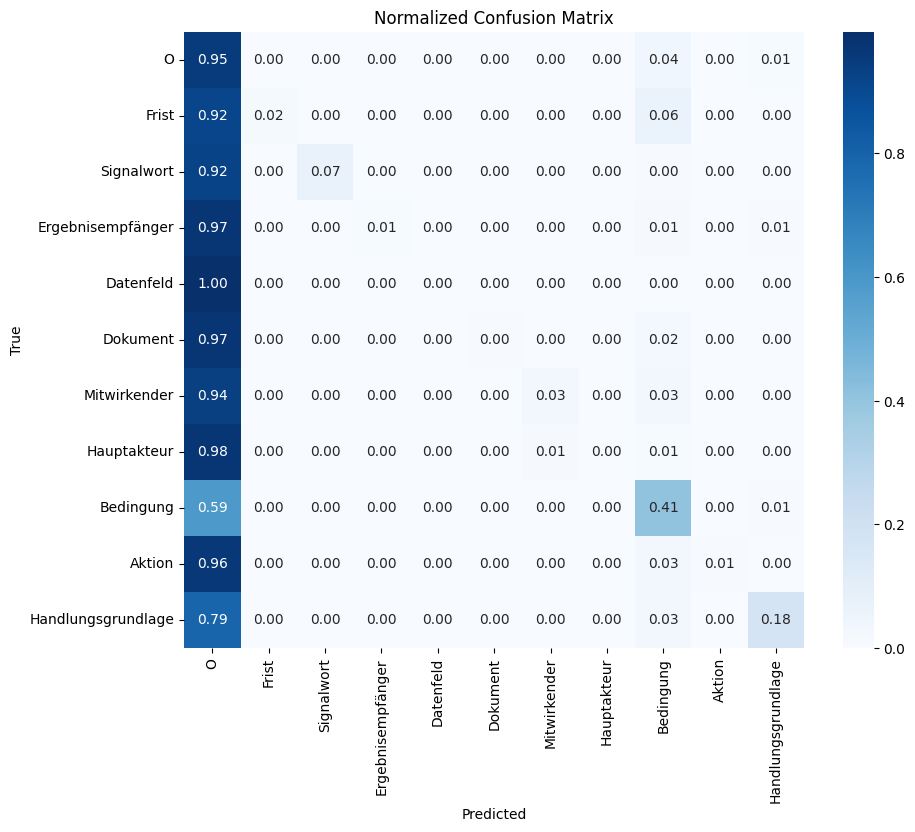

In [ ]:
pipe.print_confusion_matrix()

# T5

In [ ]:
model_name = "google-mt5"

##Training

In [ ]:
model = ModelTrainer("google/mt5-base", "google/mt5-base", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Some weights of MT5ForTokenClassification were not initialized from the model checkpoint at google/mt5-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
/usr/local/lib/python3.10/dist-packages/transformers/conver

In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x7be5724b2920>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,2.823000,1.184980,0.037037,0.000263,0.000521,0.754382
2,1.197600,1.035849,0.000000,0.000000,0.000000,0.754528


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
There were missing keys in the checkpoint model loaded: ['transformer.encoder.embed_tokens.weight'].


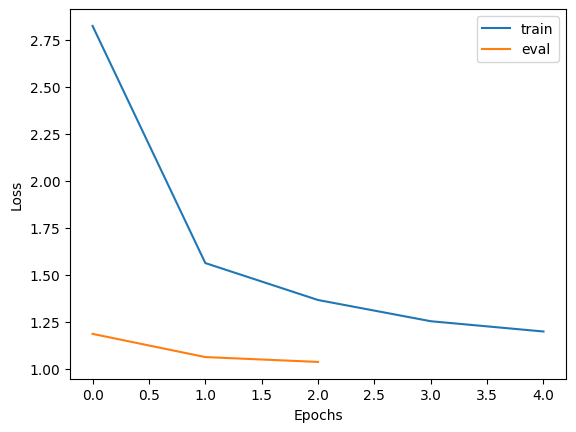

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/google-mt5/final/ (stored 0%)
  adding: content/google-mt5/final/model.safetensors (deflated 36%)
  adding: content/google-mt5/final/training_args.bin (deflated 51%)
  adding: content/google-mt5/final/tokenizer.json (deflated 76%)
  adding: content/google-mt5/final/spiece.model (deflated 46%)
  adding: content/google-mt5/final/special_tokens_map.json (deflated 73%)
  adding: content/google-mt5/final/tokenizer_config.json (deflated 95%)
  adding: content/google-mt5/final/config.json (deflated 61%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'google/mt5-base')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/admin_ner_google-mt5.zip
   creating: /content/google-mt5/final/content/google-mt5/final/
  inflating: /content/google-mt5/final/content/google-mt5/final/model.safetensors  
  inflating: /content/google-mt5/final/content/google-mt5/final/training_args.bin  
  inflating: /content/google-mt5/final/content/google-mt5/final/tokenizer.json  
  inflating: /content/google-mt5/final/content/google-mt5/final/spiece.model  
  inflating: /content/google-mt5/final/content/google-mt5/final/special_tokens_map.json  
  inflating: /content/google-mt5/final/content/google-mt5/final/tokenizer_config.json  
  inflating: /content/google-mt5/final/content/google-mt5/final/config.json  


tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/702 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting

In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


['Zum', 'Nachweis', 'der', 'Tragfähigkeit', 'der', 'Existenzgründung', 'ist', 'der', 'Agentur', 'für', 'Arbeit', 'die', 'Stellungnahme', 'einer', 'fachkundigen', 'Stelle', 'vorzulegen', ';', 'fachkundige', 'Stellen', 'sind', 'insbesondere', 'die', 'Industriekammern', '-', 'und', 'Handelskammern', ',', 'Handwerkskammern', ',', 'berufsständische', 'Kammern', ',', 'Fachverbände', 'und', 'Kreditinstitute', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-Signalwort', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Dokument', 'O', 'O', 'B-Hauptakteur', 'B-Aktion', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O']
[{'entity_group': 'Signalwort', 'score': 0.36573246, 'word': 'ist', 'start': 51, 'end': 55}, {'entity_group': 'Aktion', 'score': 0.6096355, 'word': 'vorzulegen', 'start': 122, 'end': 133}, {'entity_group': 'Dokument', 'score': 0.33882996, 'word': 'sind', 'start': 155,

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


In [ ]:
pipe.evaluate(test)

100%|██████████| 3264/3264 [01:01<00:00, 53.03it/s]


In [ ]:
pipe.print_classification_report()

                    precision    recall  f1-score   support

                 O      0.768     0.902     0.829     55054
             Frist      0.008     0.005     0.006       435
        Signalwort      0.241     0.095     0.136       717
 Ergebnisempfänger      0.013     0.007     0.009       422
         Datenfeld      0.016     0.029     0.021       581
          Dokument      0.011     0.003     0.005       712
      Mitwirkender      0.003     0.004     0.003       279
       Hauptakteur      0.005     0.003     0.004       293
         Bedingung      0.306     0.066     0.108     11174
            Aktion      0.059     0.123     0.080      1095
Handlungsgrundlage      0.075     0.042     0.054      2529

          accuracy                          0.692     73291
         macro avg      0.137     0.116     0.114     73291
      weighted avg      0.630     0.692     0.644     73291



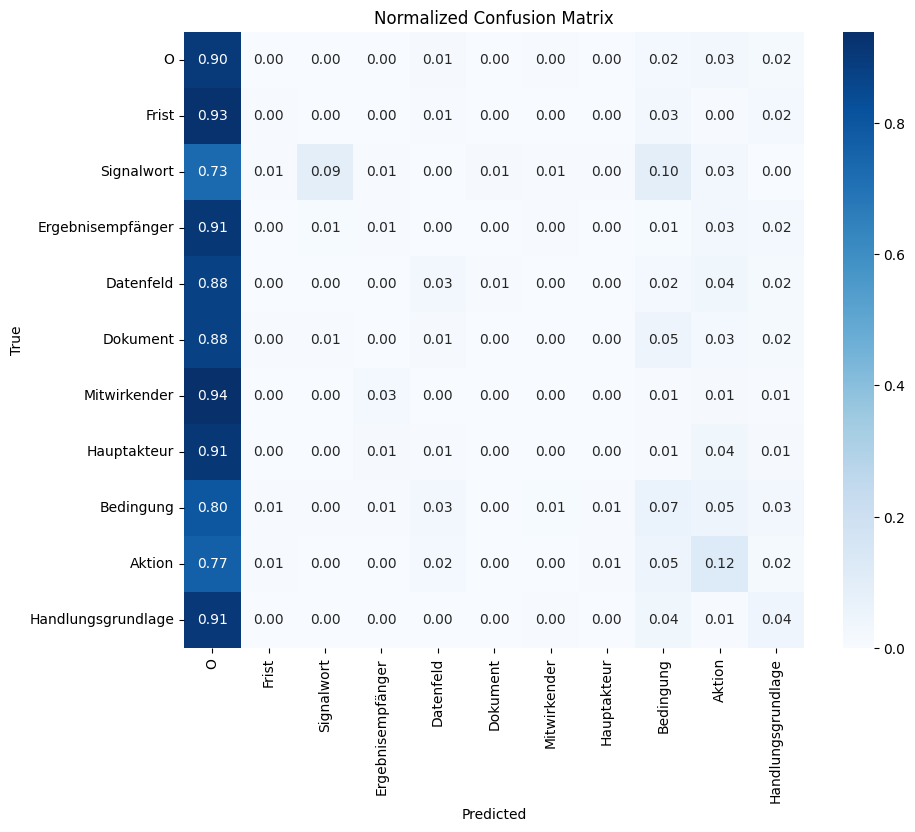

In [ ]:
pipe.print_confusion_matrix()

# XLNet

In [ ]:
model_name = "xlnet-base-cased"

##Training

In [ ]:
model = ModelTrainer("xlnet/xlnet-base-cased", "xlnet/xlnet-base-cased", ids_to_labels, labels_to_ids)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet/xlnet-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
training_args = TrainingArguments(
    output_dir=model_name,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    gradient_accumulation_steps=2,
)

model.train(train, training_args)

/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.ColabKernelApp'>.
  StockPickler.save(self, obj, save_persistent_id)
/usr/local/lib/python3.10/dist-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.ColabKernelApp'>: __main__.ColabKernelApp has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<bound method ModelTrainer.__encode_tags of <__main__.ModelTrainer object at 0x793a1c7de9e0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashi

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Map:   0%|          | 0/15716 [00:00<?, ? examples/s]

Map:   0%|          | 0/2774 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,0.916000,0.636504,0.197238,0.120517,0.149615,0.776904
2,0.536100,0.569703,0.356498,0.343618,0.349940,0.792614


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


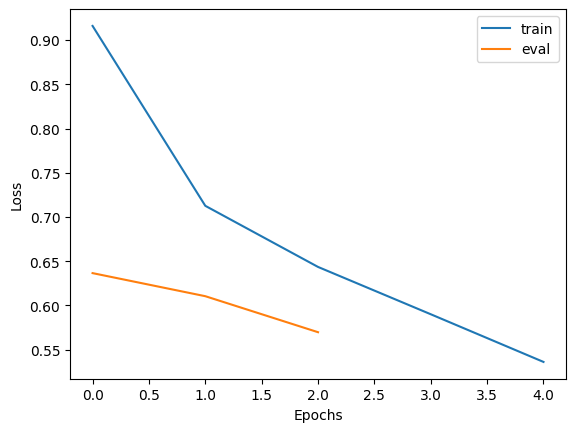

In [ ]:
model.evaluate_training()

In [ ]:
model.save(model_name)

  adding: content/xlnet-base-cased/final/ (stored 0%)
  adding: content/xlnet-base-cased/final/model.safetensors (deflated 7%)
  adding: content/xlnet-base-cased/final/training_args.bin (deflated 51%)
  adding: content/xlnet-base-cased/final/tokenizer.json (deflated 75%)
  adding: content/xlnet-base-cased/final/spiece.model (deflated 49%)
  adding: content/xlnet-base-cased/final/special_tokens_map.json (deflated 52%)
  adding: content/xlnet-base-cased/final/tokenizer_config.json (deflated 81%)
  adding: content/xlnet-base-cased/final/config.json (deflated 62%)


## Inference

In [ ]:
pipe = ModelPipe(model_name, 'xlnet/xlnet-base-cased')

Archive:  /content/drive/MyDrive/Masterarbeit/Models/admin_ner_xlnet-base-cased.zip
   creating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/model.safetensors  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/training_args.bin  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/tokenizer.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/spiece.model  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/special_tokens_map.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/tokenizer_config.json  
  inflating: /content/xlnet-base-cased/final/content/xlnet-base-cased/final/config.json  


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(test.iloc[0]['tokens'])
print(test.iloc[0]['ner_tags'])
print(pipe.inference(' '.join(test.iloc[0]['tokens'])))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:392: UserWarning: Tokenizer does not support real words, using fallback heuristic
  warnings.warn(


['Zum', 'Nachweis', 'der', 'Tragfähigkeit', 'der', 'Existenzgründung', 'ist', 'der', 'Agentur', 'für', 'Arbeit', 'die', 'Stellungnahme', 'einer', 'fachkundigen', 'Stelle', 'vorzulegen', ';', 'fachkundige', 'Stellen', 'sind', 'insbesondere', 'die', 'Industriekammern', '-', 'und', 'Handelskammern', ',', 'Handwerkskammern', ',', 'berufsständische', 'Kammern', ',', 'Fachverbände', 'und', 'Kreditinstitute', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'B-Signalwort', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Dokument', 'O', 'O', 'B-Hauptakteur', 'B-Aktion', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O', 'B-Hauptakteur', 'O']
[{'entity_group': 'Mitwirkender', 'score': 0.38940436, 'word': 'fur', 'start': 68, 'end': 71}, {'entity_group': 'Aktion', 'score': 0.50980204, 'word': '', 'start': 123, 'end': 124}]


In [ ]:
pipe.evaluate(test)

100%|██████████| 3264/3264 [01:26<00:00, 37.76it/s]


In [ ]:
pipe.print_classification_report()

                    precision    recall  f1-score   support

                 O      0.858     0.882     0.870     55054
             Frist      0.467     0.209     0.289       435
        Signalwort      0.485     0.466     0.475       717
 Ergebnisempfänger      0.452     0.213     0.290       422
         Datenfeld      1.000     0.007     0.014       581
          Dokument      0.693     0.098     0.172       712
      Mitwirkender      0.349     0.240     0.285       279
       Hauptakteur      0.513     0.403     0.451       293
         Bedingung      0.613     0.654     0.633     11174
            Aktion      0.488     0.288     0.362      1095
Handlungsgrundlage      0.481     0.476     0.478      2529

          accuracy                          0.794     73291
         macro avg      0.582     0.358     0.393     73291
      weighted avg      0.790     0.794     0.784     73291



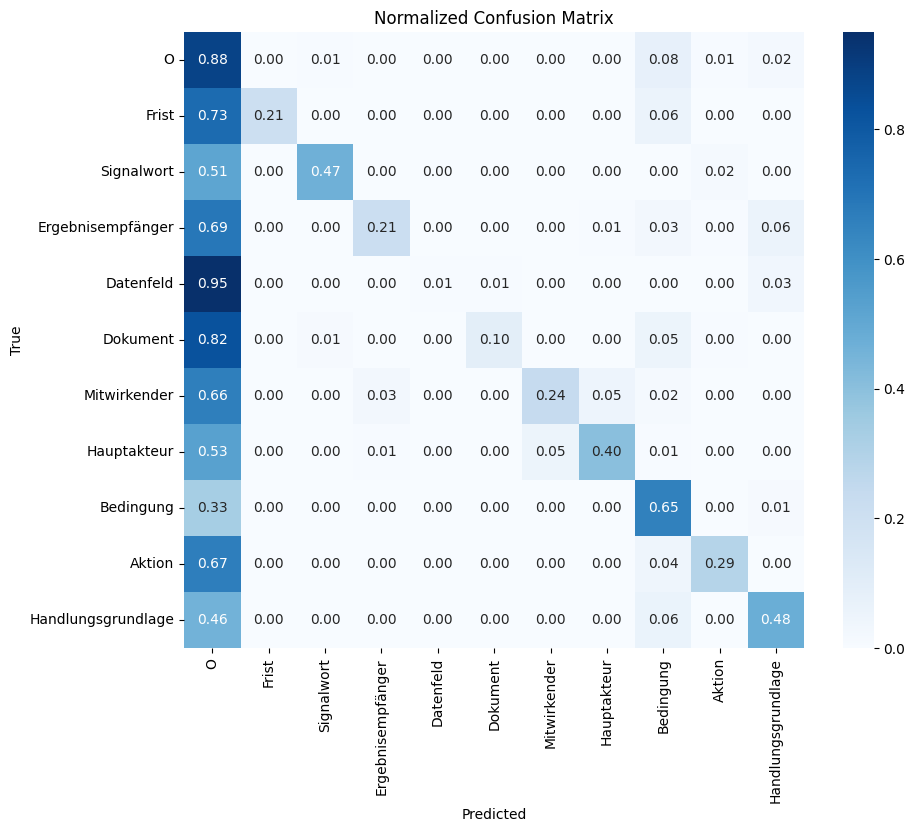

In [ ]:
pipe.print_confusion_matrix()